# SCF Calculation for Metals

In [1]:
import os
os.environ['ASE_ESPRESSO_COMMAND'] = "mpirun -np 4 pw.x -in PREFIX.pwi > PREFIX.pwo"
os.environ['OMP_NUM_THREADS'] = "1"

If you are running on Bridges2, run this block

In [ ]:
import sys
sys.path.append("/usr/share/lmod/lmod/init")
sys.path.append("/jet/home/YOURNAME/.conda/envs/icomse-dft/lib/python3.1/site-packages/")
from env_modules_python import module
module('load', 'intelmpi')
module('load', 'QuantumEspresso')

In [7]:
from ase.build import bulk
from ase.visualize import view
atoms = bulk("Al", "fcc")
view(atoms, viewer="x3d")

In [26]:
from ase.calculators.espresso import Espresso

pseudopotentials = {
    "Al":"Al.pbe-n-kjpaw_psl.1.0.0.UPF"
}

input_data = {
    'system': {
        'ecutwfc': 30,
        'ecutrho': 120,
        'occupations': 'smearing',
        'smearing':'cold',
        'degauss':0.005
    },
    'control': {
        'restart_mode': 'from_scratch',
        'pseudo_dir': '../pseudos'
    },
    'electrons': {
        'diagonalization':'david',
        'conv_thr': 1.0e-8, 
        'mixing_beta':0.4
    }
} 


calc = Espresso(
    pseudopotentials=pseudopotentials,
    tstress=True, tprnfor=True, 
    input_data = input_data,
    kpts=(8,8,8),
    koffset=(1, 1, 1))

atoms.calc = calc


In [9]:
energy = atoms.get_potential_energy()
print(f"E = {energy:.3f}")

E = -537.466


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


# K-Point Covnergence

In [10]:
kpoints = range(1,9) 
energies = []
for k in kpoints:
    calc.set(kpts=(k, k, k))
    energies.append(atoms.get_potential_energy())
    

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


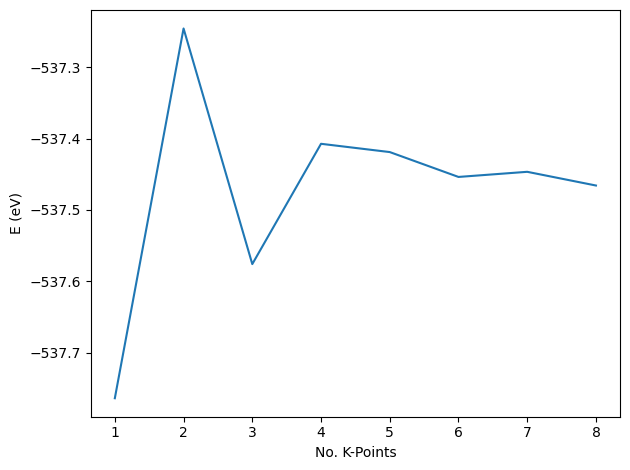

In [11]:
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.plot(kpoints, energies)
plt.xlabel("No. K-Points")
plt.ylabel("E (eV)")
plt.tight_layout()
plt.show()

In [25]:
calc.set(kpts = (8,8,8))

{'kpts': (8, 8, 8)}

# Equation of State Fitting

In [14]:
from ase.io.trajectory import Trajectory
import numpy as np
cell0 = atoms.get_cell()
atoms.calc = calc

traj = Trajectory('Al_murnaghan.traj', 'w')
for x in np.linspace(0.95, 1.05, 5):
    atoms.set_cell(cell0 * x, scale_atoms=True)
    atoms.get_potential_energy()
    traj.write(atoms)

atoms.set_cell(cell0, scale_atoms=True)

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


See full list of EOS options at https://databases.fysik.dtu.dk/ase/ase/eos.html

2.5422055975065945 Ang.
76.46884124032786 GPa


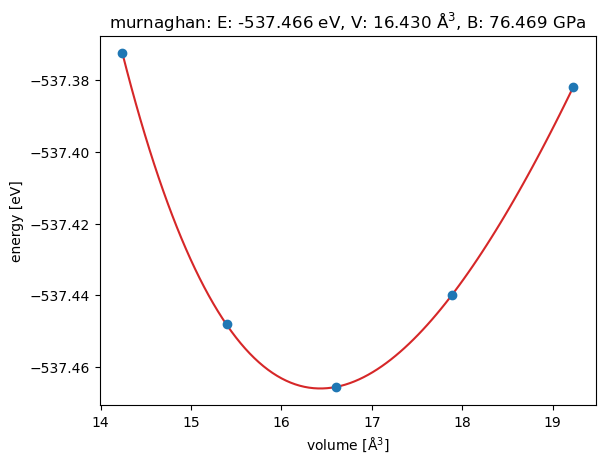

In [20]:
from ase.io import read, write
from ase.eos import EquationOfState
from ase import units

configs = read("Al_murnaghan.traj@0:5")
volumes = [ag.get_volume() for ag in configs]
energies = [ag.get_potential_energy() for ag in configs]
eos = EquationOfState(volumes, energies, eos="murnaghan")
v0, e0, B = eos.fit()
print(v0**(1./3.), "Ang.")
print(B / units.kJ * 1.0e24, 'GPa')
eos.plot()
pass

# Density of States

In [28]:
from ase.dft.dos import DOS
atoms.get_potential_energy()
dos = DOS(calc, width=0.2)
d = dos.get_dos()
e = dos.get_energies()

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


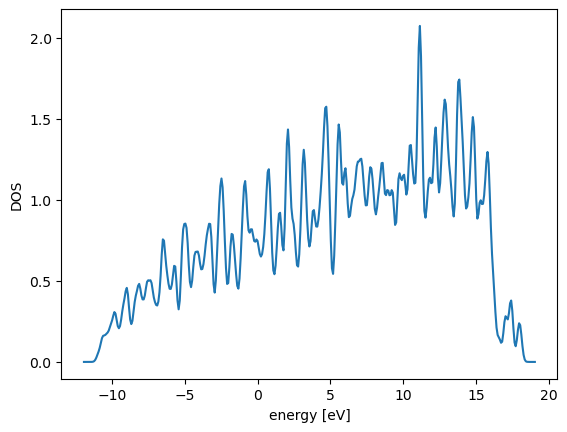

In [29]:
plt.plot(e, d)
plt.xlabel('energy [eV]')
plt.ylabel('DOS')
plt.show()

In [30]:
from ase.dft import get_distribution_moment
volume = get_distribution_moment(e,d)
center, width = get_distribution_moment(e,d,(1,2))
print(center, "+/-", width)

5.509670638020809 +/- 81.25787272160714


# Band Structure

In [31]:
atoms.get_potential_energy()
fermi_level = calc.get_fermi_level()

In [34]:
atoms.get_cell()

Cell([[0.0, 2.025, 2.025], [2.025, 0.0, 2.025], [2.025, 2.025, 0.0]])

FCC(a=4.05)
  Variant name: FCC
  Special point names: GKLUWX
  Default path: GXWKGLUWLK,UX

  Special point coordinates:
    G   0.0000  0.0000  0.0000
    K   0.3750  0.3750  0.7500
    L   0.5000  0.5000  0.5000
    U   0.6250  0.2500  0.6250
    W   0.5000  0.2500  0.7500
    X   0.5000  0.0000  0.5000



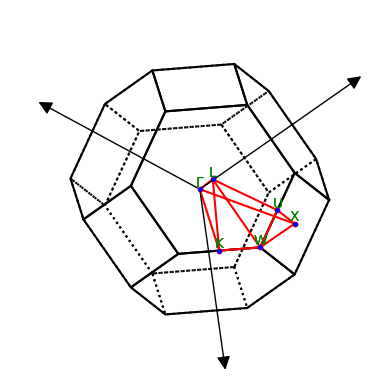

<Axes3D: >

In [35]:
lat = atoms.cell.get_bravais_lattice()
print(lat.description())
lat.plot_bz(show=True)

In [43]:
kpath = atoms.cell.bandpath()
kpath

BandPath(path='GXWKGLUWLK,UX', cell=[3x3], special_points={GKLUWX}, kpts=[50x3])

In [44]:
input_data['control'].update(
    {
        'calculation':'bands',
        'restart_mode':'restart',
        'verbosity':'high'
    }
)
calc.set(
    kpts=kpath,
    input_data=input_data
)

calc.calculate(atoms)


<Axes: ylabel='energies [eV]'>

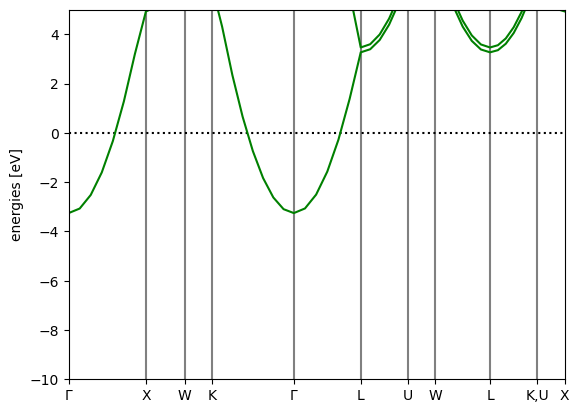

In [45]:
bs = calc.band_structure()
bs.plot()